In [1]:
import numpy as np
import pandas as pd

from src.data_download import get_data_from_tradingview

constituents = pd.read_excel(
    '../data/SP100_constituent.xlsx'
)

In [2]:
from tvDatafeed import Interval

prices = get_data_from_tradingview(
    tickers = constituents['Symbol'].tolist(),
    exchange = constituents['Exchange'].tolist(),
    interval = Interval.in_daily,
    n_bars = 13000,
    column = 'close',
    verbose = True
)

you are using nologin method, data you access may be limited
84it [03:32,  4.90s/it]ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
100it [05:17,  3.17s/it]


### Fractional Diffrentiation

In [29]:
from statsmodels.tsa.stattools import adfuller
from joblib import Parallel, delayed

def get_weights_ffd(d, thres, size):
    w = [1.0]
    for k in range(1, size):
        w_ = -w[-1] * (d - k + 1) / k
        if abs(w_) < thres:
            break
        w.append(w_)
    return np.array(w[::-1]).reshape(-1, 1)

def frac_diff_ffd(series, d, thres = 1e-4):
    series = series.dropna()
    w = get_weights_ffd(d, thres, len(series))
    width = len(w) - 1

    series_f = series.ffill().dropna()
    res = []
    for i in range(width, series_f.shape[0]):
        res.append(np.dot(w.T, series_f.iloc[i-width:i+1])[0])

    return pd.Series(res, index=series_f.index[width:])

def find_optimal_d_and_diff(series, name):
    for d in np.linspace(0, 1, 21):
        diff_series = frac_diff_ffd(series, d)
        if diff_series.empty: continue

        p_val = adfuller(diff_series, maxlag=1, regression='c', autolag=None)[1]
        if p_val < 0.05:
            return name, d, diff_series

    return name, 1.0, frac_diff_ffd(series, 1.0)

def parallel_frac_diff(df, n_jobs=-1) -> tuple:
    print(f"Starting parallel FracDiff on {len(df.columns)} assets...")

    results = Parallel(n_jobs=n_jobs)(
        delayed(find_optimal_d_and_diff)(df[col], col) for col in df.columns
    )
    d_stats = {}
    diff_dfs = []

    for name, d, series in results:
        d_stats[name] = round(float(d),2)
        diff_dfs.append(series)

    final_df = pd.concat(diff_dfs, axis=1)
    final_df.columns = df.columns # rename columns

    return final_df, d_stats

In [30]:
fracdiff_price, d_values = parallel_frac_diff(np.log(prices), n_jobs = -2)

Starting parallel FracDiff on 100 assets...


In [31]:
d_values

{'AAPL': 0.3,
 'ABBV': 0.2,
 'ABT': 0.3,
 'ACN': 0.25,
 'ADBE': 0.25,
 'AIG': 0.15,
 'AMD': 0.15,
 'AMGN': 0.05,
 'AMT': 0.2,
 'AMZN': 0.25,
 'AVGO': 0.3,
 'AXP': 0.25,
 'BA': 0.2,
 'BAC': 0.15,
 'BK': 0.2,
 'BKNG': 0.25,
 'BLK': 0.2,
 'BMY': 0.2,
 'BRK.B': 0.25,
 'C': 0.15,
 'CAT': 0.25,
 'CL': 0.3,
 'CMCSA': 0.05,
 'COF': 0.05,
 'COP': 0.2,
 'COST': 0.25,
 'CRM': 0.2,
 'CSCO': 0.0,
 'CVS': 0.2,
 'CVX': 0.2,
 'DE': 0.25,
 'DHR': 0.3,
 'DIS': 0.25,
 'DUK': 0.2,
 'EMR': 0.25,
 'FDX': 0.2,
 'GD': 0.25,
 'GE': 0.2,
 'GILD': 0.25,
 'GM': 0.1,
 'GOOGL': 0.3,
 'GS': 0.2,
 'HD': 0.0,
 'HON': 0.2,
 'IBM': 0.2,
 'INTC': 0.25,
 'INTU': 0.2,
 'ISRG': 0.25,
 'JNJ': 0.3,
 'JPM': 0.2,
 'KO': 0.3,
 'LIN': 0.25,
 'LLY': 0.25,
 'LMT': 0.25,
 'LOW': 0.3,
 'MA': 0.3,
 'MCD': 0.3,
 'MDLZ': 0.2,
 'MDT': 0.3,
 'MET': 0.0,
 'META': 0.2,
 'MMM': 0.25,
 'MO': 0.3,
 'MRK': 0.25,
 'MS': 0.1,
 'MSFT': 0.25,
 'NEE': 0.3,
 'NFLX': 0.3,
 'NKE': 0.25,
 'NOW': 0.25,
 'NVDA': 0.3,
 'ORCL': 0.2,
 'PEP': 0.3,
 'PFE': 0.2

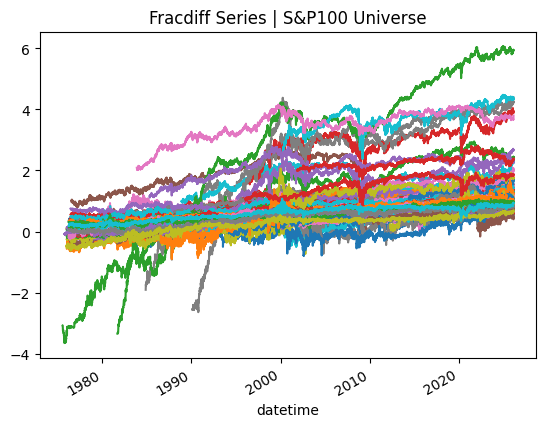

In [33]:
import matplotlib.pyplot as plt

fracdiff_price.plot(legend = False)
plt.title('Fracdiff Series | S&P100 Universe')
plt.show()

### Calculating Mutual Information (distance)

In [34]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import KBinsDiscretizer

import itertools

def calculate_mutual_info_pair(
        data : pd.DataFrame,
        asset_i : str,
        asset_j : str
    ) -> tuple :
    "calculate mutual information between asset i and asset j"
    x = data.iloc[:, asset_i].values.reshape(-1, 1)
    y = data.iloc[:, asset_j].values

    mutual_information = mutual_info_regression(
        x, y,
        n_neighbors = 3,
        random_state = 42
    )[0]
    return asset_i, asset_j, mutual_information

In [51]:
def get_mutual_info_matrix(
        data : pd.DataFrame,
        n_jobs : int = -1
    ) -> pd.DataFrame :
    n_assets = data.shape[1]
    asset_names = data.columns

    print(f"Calculating MI for {n_assets} assets ({n_assets*(n_assets-1)//2} pairs)...")

    pairs = list(itertools.combinations(range(n_assets), 2))

    results = Parallel(n_jobs=n_jobs)(
        delayed(calculate_mutual_info_pair)(data, i, j) for i, j in pairs
    )

    mi_matrix = np.zeros((n_assets, n_assets))

    for i, j, mi in results:
        mi_matrix[i, j] = mi
        mi_matrix[j, i] = mi

    for i in range(n_assets):
        mi_matrix[i, i] = mutual_info_regression(
            data.iloc[:, i].values.reshape(-1, 1),
            data.iloc[:, i].values,
            n_neighbors=3, random_state=42
        )[0]

    dist_matrix = np.zeros((n_assets, n_assets))
    for i, j in itertools.combinations(range(n_assets), 2):
        h_x = mi_matrix[i, i]
        h_y = mi_matrix[j, j]
        mi_xy = mi_matrix[i, j]

        nmi = mi_xy / max(h_x, h_y, 1e-10)
        distance = max(0, 1 - nmi)

        dist_matrix[i, j] = distance
        dist_matrix[j, i] = distance

    return pd.DataFrame(dist_matrix, index=asset_names, columns=asset_names)

In [61]:
import warnings

from sklearn.metrics import mutual_info_score
from tqdm import tqdm

warnings.filterwarnings('ignore')

def calculate_discrete_mi_matrix(df, bins=10):
    n_assets = df.shape[1]

    kbd = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
    df_discrete = pd.DataFrame(kbd.fit_transform(df), columns=df.columns)

    h_list = []
    for i in range(n_assets):
        h = mutual_info_score(df_discrete.iloc[:, i], df_discrete.iloc[:, i])
        h_list.append(h)

    dist_matrix = np.zeros((n_assets, n_assets))
    for i in tqdm(range(n_assets)):
        for j in range(i + 1, n_assets):
            mi = mutual_info_score(df_discrete.iloc[:, i], df_discrete.iloc[:, j])

            nmi = mi / max(h_list[i], h_list[j])

            distance = max(0, 1 - nmi)

            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance

    return pd.DataFrame(dist_matrix, index=df.columns, columns=df.columns)

In [62]:
test_mi = calculate_discrete_mi_matrix(
    fracdiff_price.loc['2016':].dropna(axis = 1),
    bins = 10
)

100%|██████████| 97/97 [00:02<00:00, 33.33it/s]


In [63]:
test_mi

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
AAPL,0.000000,0.768620,0.773128,0.705958,0.761179,0.888739,0.615790,0.684070,0.850728,0.730310,...,0.743833,0.766204,0.767174,0.825322,0.930938,0.713714,0.836518,0.901068,0.734094,0.860612
ABBV,0.768620,0.000000,0.823479,0.807735,0.844268,0.808188,0.775708,0.711705,0.871513,0.818383,...,0.824019,0.754703,0.837545,0.826934,0.950201,0.774928,0.789286,0.875950,0.774675,0.811975
ABT,0.773128,0.823479,0.000000,0.747963,0.789944,0.917283,0.757577,0.759076,0.809848,0.767055,...,0.780530,0.831621,0.756814,0.884315,0.969985,0.719336,0.871413,0.936483,0.791435,0.920944
ACN,0.705958,0.807735,0.747963,0.000000,0.732419,0.923519,0.697010,0.756128,0.853321,0.777673,...,0.720175,0.755407,0.704658,0.820840,0.950511,0.719796,0.876487,0.941241,0.800216,0.897892
ADBE,0.761179,0.844268,0.789944,0.732419,0.000000,0.922974,0.771774,0.804201,0.817309,0.721377,...,0.800669,0.795112,0.785951,0.872266,0.945687,0.735094,0.879028,0.938540,0.815024,0.905424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V,0.713714,0.774928,0.719336,0.719796,0.735094,0.845835,0.718236,0.703081,0.825839,0.724475,...,0.769379,0.800088,0.745629,0.862828,0.958835,0.000000,0.790512,0.878548,0.707674,0.876615
VZ,0.836518,0.789286,0.871413,0.876487,0.879028,0.804129,0.800573,0.755460,0.826254,0.849287,...,0.893426,0.854369,0.880293,0.852768,0.933326,0.790512,0.000000,0.883654,0.772013,0.797084
WFC,0.901068,0.875950,0.936483,0.941241,0.938540,0.781213,0.866167,0.877917,0.949851,0.882492,...,0.935600,0.945766,0.917790,0.885786,0.849954,0.878548,0.883654,0.000000,0.857517,0.857127
WMT,0.734094,0.774675,0.791435,0.800216,0.815024,0.820615,0.745715,0.697357,0.840319,0.746897,...,0.808187,0.830942,0.816154,0.825511,0.935054,0.707674,0.772013,0.857517,0.000000,0.860291


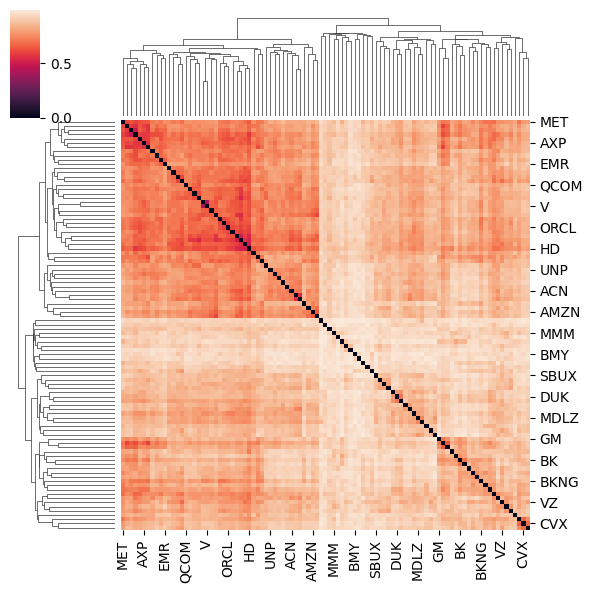

In [64]:
import seaborn as sns

sns.clustermap(test_mi, figsize = (6,6))

### Clustering (ONC Algorithm)

In [97]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA

def evaluate_k(
        k : int,
        linkage_matrix : np.ndarray,
        dist_matrix : np.ndarray,
    ) -> tuple:
    """
    Evaluates the clustering quality for a given k using the silhouette score.
    """
    # Assign cluster labels based on the linkage matrix for a specific k
    labels = fcluster(linkage_matrix, t=k, criterion='maxclust')

    # Handle cases where clustering fails to produce at least 2 clusters
    if len(np.unique(labels)) < 2:
        return k, -1

    # Calculate silhouette score using the precomputed distance matrix
    score = silhouette_score(
        dist_matrix,
        labels,
        metric='precomputed'
    )
    return k, score

def get_cluster_representatives(
    data: pd.DataFrame,
    mi_dist_df: pd.DataFrame,
    max_k: int = 10,
    n_jobs: int = -1
) -> tuple:
    """
    Performs Optimal Number of Clusters (ONC) search and extracts the
    first principal component (PC1) for each cluster.

    Args:
        data: Standardized/FracDiff time-series DataFrame (Assets as columns).
        mi_dist_df: Precomputed Mutual Information distance matrix.
        max_k: Maximum number of clusters to explore.
        n_jobs: Number of CPU cores for parallel processing (-1 uses all).

    Returns:
        pc1_df: DataFrame containing the PC1 time-series for each cluster.
        clusters: Series mapping each asset to its assigned cluster.
    """
    print(f"🚀 Starting ONC Algorithm: Parallel search from k=2 to {max_k} (n_jobs={n_jobs})")

    # Perform hierarchical clustering using the average linkage method
    dist_array = mi_dist_df.values
    linkage_matrix = linkage(dist_array, method='average')

    # Parallel search for the optimal k based on the silhouette score
    # Wrapped in list brackets [] to avoid SyntaxError in certain Python environments
    results = Parallel(n_jobs=n_jobs)(
        [delayed(evaluate_k)(k, linkage_matrix, dist_array) for k in tqdm(range(2, max_k + 1), desc="Progress of ONC Exploration")]
    )

    # Extract the k value with the highest silhouette score
    best_k, best_score = max(results, key=lambda x: x[1])
    print(f"✅ Optimal number of clusters found: {best_k} (Best Silhouette Score: {best_score:.4f})")

    # Perform final clustering with the optimal k
    final_labels = fcluster(
        linkage_matrix,
        t = best_k,
        criterion = 'maxclust'
    )
    clusters = pd.Series(final_labels, index=data.columns)

    # Extract the First Principal Component (PC1) for each cluster node
    pc1_dict = {}
    for c in range(1, best_k + 1):
        assets_in_cluster = clusters[clusters == c].index
        cluster_data = data[assets_in_cluster]

        # Condense the cluster information into a single latent causal node via PCA
        pca = PCA(n_components=1)
        pc1_series = pca.fit_transform(cluster_data).flatten()
        pc1_dict[f'Cluster_{c}'] = pc1_series

    # Construct the final DataFrame for Causal Discovery (NOTEARS/DYNOTEARS)
    pc1_df = pd.DataFrame(pc1_dict, index=data.index)

    return (pc1_df, clusters)

In [98]:
def get_assets_by_cluster(cluster_mapping):
    cluster_dict = {}
    unique_clusters = sorted(cluster_mapping.unique())

    print(f"=== 클러스터별 자산 할당 결과 (총 {len(unique_clusters)}개 그룹) ===\n")

    for c in unique_clusters:
        assets = cluster_mapping[cluster_mapping == c].index.tolist()
        cluster_dict[f'Cluster_{c}'] = assets

        print(f"Cluster {c} ({len(assets)}개 자산):")
        print(f"   {', '.join(assets)}")
        print("-" * 50)

    return cluster_dict

In [99]:
pc1_df, cluster_mapping = get_cluster_representatives(
    fracdiff_price.loc['2016':].dropna(axis = 1),
    test_mi,
    max_k = 20,
    n_jobs = -2
)

🚀 Starting ONC Algorithm: Parallel search from k=2 to 20 (n_jobs=-2)


Progress of ONC Exploration: 100%|██████████| 19/19 [00:00<00:00, 244453.30it/s]

✅ Optimal number of clusters found: 13 (Best Silhouette Score: 0.0487)


In [100]:
get_assets_by_cluster(cluster_mapping)

=== 클러스터별 자산 할당 결과 (총 13개 그룹) ===

Cluster 1 (47개 자산):
   AAPL, ABT, ACN, ADBE, AMD, AMGN, AMZN, AVGO, AXP, BLK, BRK.B, CAT, COF, COST, CRM, CSCO, DE, DHR, EMR, GE, GOOGL, GS, HD, HON, INTU, ISRG, JPM, LIN, LLY, LOW, MA, MET, META, MS, MSFT, NFLX, NOW, NVDA, ORCL, QCOM, TMO, TMUS, TSLA, TXN, UNP, V, WMT
--------------------------------------------------
Cluster 2 (1개 자산):
   CL
--------------------------------------------------
Cluster 3 (1개 자산):
   JNJ
--------------------------------------------------
Cluster 4 (2개 자산):
   MMM, MO
--------------------------------------------------
Cluster 5 (3개 자산):
   DIS, MDT, USB
--------------------------------------------------
Cluster 6 (1개 자산):
   FDX
--------------------------------------------------
Cluster 7 (2개 자산):
   BMY, CVS
--------------------------------------------------
Cluster 8 (1개 자산):
   INTC
--------------------------------------------------
Cluster 9 (1개 자산):
   PFE
--------------------------------------------------
Cluster 1

{'Cluster_1': ['AAPL',
  'ABT',
  'ACN',
  'ADBE',
  'AMD',
  'AMGN',
  'AMZN',
  'AVGO',
  'AXP',
  'BLK',
  'BRK.B',
  'CAT',
  'COF',
  'COST',
  'CRM',
  'CSCO',
  'DE',
  'DHR',
  'EMR',
  'GE',
  'GOOGL',
  'GS',
  'HD',
  'HON',
  'INTU',
  'ISRG',
  'JPM',
  'LIN',
  'LLY',
  'LOW',
  'MA',
  'MET',
  'META',
  'MS',
  'MSFT',
  'NFLX',
  'NOW',
  'NVDA',
  'ORCL',
  'QCOM',
  'TMO',
  'TMUS',
  'TSLA',
  'TXN',
  'UNP',
  'V',
  'WMT'],
 'Cluster_2': ['CL'],
 'Cluster_3': ['JNJ'],
 'Cluster_4': ['MMM', 'MO'],
 'Cluster_5': ['DIS', 'MDT', 'USB'],
 'Cluster_6': ['FDX'],
 'Cluster_7': ['BMY', 'CVS'],
 'Cluster_8': ['INTC'],
 'Cluster_9': ['PFE'],
 'Cluster_10': ['GILD'],
 'Cluster_11': ['AMT',
  'CMCSA',
  'DUK',
  'KO',
  'LMT',
  'MCD',
  'MDLZ',
  'MRK',
  'NEE',
  'NKE',
  'PEP',
  'PG',
  'SBUX',
  'SO',
  'TGT'],
 'Cluster_12': ['AIG',
  'BAC',
  'BK',
  'BKNG',
  'C',
  'GD',
  'GM',
  'IBM',
  'PM',
  'RTX',
  'SCHW',
  'SPG',
  'WFC'],
 'Cluster_13': ['ABBV', 'BA', 'COP'

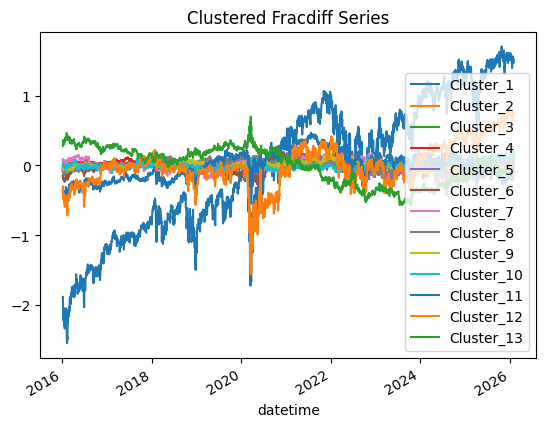

In [101]:
pc1_df.plot()
plt.title('Clustered Fracdiff Series')
plt.show()

### Control Outlier assets

In [102]:
def get_asset_cluster_signals(
        data : pd.DataFrame,
        cluster_mapping : dict,
        min_assets : int = 3
    ) -> tuple :
    """
    Extracts PC1 signals ONLY from clusters that meet the minimum size requirement.

    Args:
        standardized_df: DataFrame of FracDiff + Standardized asset returns.
        cluster_mapping: Series mapping asset names to cluster IDs.
        min_assets: Minimum number of assets required to keep a cluster.

    Returns:
        asset_signals_df: DataFrame of PC1 signals for valid clusters.
        valid_cluster_list: List of cluster IDs that were kept.
    """
    # 1. Filter valid clusters
    counts = cluster_mapping.value_counts()
    valid_clusters = counts[counts >= min_assets].index.tolist()

    print(f"🔍 Total Clusters Found: {len(counts)}")
    print(f"🧹 Small Clusters Filtered (<{min_assets} assets): {len(counts) - len(valid_clusters)}")
    print(f"✅ Final Asset Nodes for DAG: {len(valid_clusters)}")

    # 2. Extract PC1
    pc1_dict = {}
    for c in sorted(valid_clusters):
        assets = cluster_mapping[cluster_mapping == c].index
        pca = PCA(n_components=1)
        pc1 = pca.fit_transform(data[assets]).flatten()
        pc1_dict[f'Cluster_{c}'] = pc1

    asset_signals_df = pd.DataFrame(pc1_dict, index = data.index)

    return asset_signals_df, sorted(valid_clusters)

In [103]:
asset_signals, valid_clusters = get_asset_cluster_signals(
    data = fracdiff_price.loc['2016':].dropna(axis = 1),
    cluster_mapping = cluster_mapping ,
    min_assets = 3
)

🔍 Total Clusters Found: 13
🧹 Small Clusters Filtered (<3 assets): 8
✅ Final Asset Nodes for DAG: 5


In [106]:
asset_signals

,Cluster_1,Cluster_5,Cluster_11,Cluster_12,Cluster_13
datetime,,,,,
2016-01-04,-1.888578,-0.078420,-0.383135,-0.299872,0.279031
2016-01-05,-1.879691,-0.077436,-0.341733,-0.298088,0.274648
2016-01-06,-1.978513,-0.082375,-0.369558,-0.355833,0.291413
2016-01-07,-2.158500,-0.100915,-0.421419,-0.448546,0.309254
2016-01-08,-2.206858,-0.103590,-0.442846,-0.481477,0.325236
...,...,...,...,...,...
2026-01-27,1.526629,0.049959,-0.059728,0.743583,-0.174853
2026-01-28,1.511515,0.033169,-0.095328,0.709016,-0.160412
2026-01-29,1.480920,0.056356,-0.049988,0.761805,-0.155953
